# Forecasting with BiLSTM...
## Write results here:

https://towardsdatascience.com/predictive-analytics-time-series-forecasting-with-gru-and-bilstm-in-tensorflow-87588c852915



In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.preprocessing import MinMaxScaler, StandardScaler

import warnings
warnings.filterwarnings('ignore')

from scipy import stats
%matplotlib inline

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, callbacks
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
# Set random seed to get the same result after each time running the code
tf.random.set_seed(1234)

In [ ]:
df = pd.read_csv("/content/sample_data/daily-website-visitors.csv")

df['Date'] = pd.to_datetime(df.Date, format='%m/%d/%Y')
df['Page.Loads'] = df['Page.Loads'].str.replace(',', '')
df['Count'] = df['Page.Loads'].astype(str).astype(int)
df = df[['Date', 'Count']]
df.set_index('Date', inplace=True)

# take data upto 12/31/2019
df = df[df.index <= '12/31/2019']

In [ ]:
# Split train data and test data
train_size = int(len(df)*0.9)
train_data = df.iloc[:train_size]
test_data = df.iloc[train_size:]

In [ ]:
# Scale data
# The input to scaler.fit -> array-like, sparse matrix, dataframe of shape (n_samples, n_features)
scaler = MinMaxScaler().fit(train_data)

train_scaled = scaler.transform(train_data)
test_scaled = scaler.transform(test_data)

In [ ]:
# Create input dataset
# Th input shape should be [samples, time steps, features]
def create_dataset (X, look_back = 1):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

X_train, y_train = create_dataset(train_scaled,30)
X_test, y_test = create_dataset(test_scaled,30)

print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('X_test.shape: ', X_test.shape) 
print('y_test.shape: ', y_test.shape)


X_train.shape:  (1711, 30, 1)
y_train.shape:  (1711, 1)
X_test.shape:  (164, 30, 1)
y_test.shape:  (164, 1)


# Creating GRU and BiLSTM models 

In [ ]:
# Create GRU model
def create_gru(units):
    model = Sequential()
    # Input layer 
    model.add(GRU (units = units, return_sequences = True, 
                 input_shape = [X_train.shape[1], X_train.shape[2]]))
    model.add(Dropout(0.2)) 
    # Hidden layer
    model.add(GRU(units = units))                 
    model.add(Dropout(0.2))
    model.add(Dense(units = 1)) 
    #Compile model
    model.compile(optimizer='adam',loss='mse')
   
    return model
model_gru = create_gru(64)

# Create BiLSTM model
def create_bilstm(units):
    model = Sequential()
    # Input layer
    model.add(Bidirectional(LSTM(units = units, return_sequences=True), 
                            input_shape=(X_train.shape[1], X_train.shape[2])))
    # Hidden layer
    model.add(Bidirectional(LSTM(units = units)))
    model.add(Dense(1))
    #Compile model
    model.compile(optimizer='adam',loss='mse')
    return model

model_bilstm = create_bilstm(64)

def fit_model(model):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                               patience = 10)
    history = model.fit(X_train, y_train, epochs = 100, validation_split = 0.2,
                    batch_size = 16, shuffle = False, callbacks = [early_stop])
    return history

history_gru = fit_model(model_gru)
history_bilstm = fit_model(model_bilstm)


Epoch 1/100
86/86 [==============================] - 8s 40ms/step - loss: 0.0405 - val_loss: 0.0350
Epoch 2/100
86/86 [==============================] - 3s 31ms/step - loss: 0.0275 - val_loss: 0.0259
Epoch 3/100
86/86 [==============================] - 3s 30ms/step - loss: 0.0171 - val_loss: 0.0103
Epoch 4/100
86/86 [==============================] - 3s 31ms/step - loss: 0.0109 - val_loss: 0.0086
Epoch 5/100
86/86 [==============================] - 3s 30ms/step - loss: 0.0093 - val_loss: 0.0077
Epoch 6/100
86/86 [==============================] - 3s 30ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 7/100
86/86 [==============================] - 3s 30ms/step - loss: 0.0063 - val_loss: 0.0048
Epoch 8/100
86/86 [==============================] - 3s 30ms/step - loss: 0.0058 - val_loss: 0.0050
Epoch 9/100
86/86 [==============================] - 3s 30ms/step - loss: 0.0058 - val_loss: 0.0047
Epoch 10/100
86/86 [==============================] - 3s 30ms/step - loss: 0.0051 - val_loss: 0.0042

# Model Performance

In [ ]:
# Transform data back to original data space
y_test = scaler.inverse_transform(y_test)
y_train = scaler.inverse_transform(y_train)

In [ ]:
# Make prediction
def prediction(model):
    prediction = model.predict(X_test)
    prediction = scaler.inverse_transform(prediction)
    return prediction

prediction_gru = prediction(model_gru)
prediction_bilstm = prediction(model_bilstm)

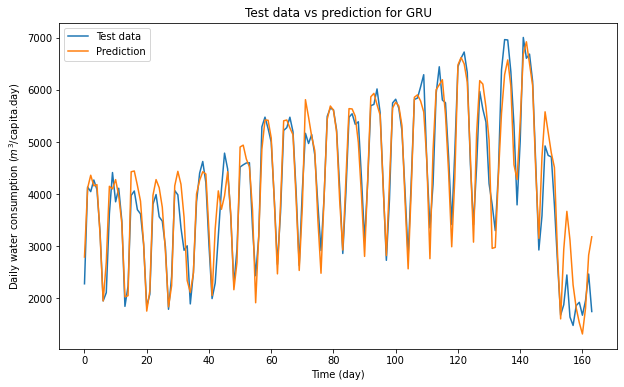

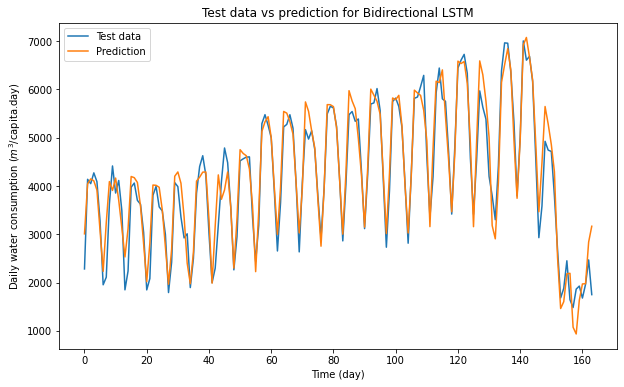

In [ ]:
# Plot test data vs prediction
def plot_future(prediction, model_name, y_test):
    
    plt.figure(figsize=(10, 6))
    
    range_future = len(prediction)

    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(prediction),label='Prediction')

    plt.title('Test data vs prediction for ' + model_name)
    plt.legend(loc='upper left')
    plt.xlabel('Time (day)')
    plt.ylabel('Daily water consumption ($m^3$/capita.day)')
       
plot_future(prediction_gru, 'GRU', y_test)
plot_future(prediction_bilstm, 'Bidirectional LSTM', y_test)

In [ ]:
# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    mae = np.abs(errors).mean()
    nrmse = rmse/(max(df['Count'])-min(df['Count']))

    print(model_name + ':')
    print('Mean Absolute Error: {:.3f}'.format(mae))
    print('Root Mean Square Error: {:.3f}'.format(rmse))
    print('Normalized Root Mean Square Error: {:.3f}'.format(nrmse))
    print()

evaluate_prediction(prediction_gru, y_test, 'GRU')
evaluate_prediction(prediction_bilstm, y_test, 'Bidirectiona LSTM')

GRU:
Mean Absolute Error: 301.383
Root Mean Square Error: 413.783
Normalized Root Mean Square Error: 0.059

Bidirectiona LSTM:
Mean Absolute Error: 287.900
Root Mean Square Error: 380.991
Normalized Root Mean Square Error: 0.055

